<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Avance5/Avance5.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 5: Modelo Final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Ricardo Ambrocio Ramírez Mendoza  – Profesor Tutor

#### **Miembros del equipo:**
- Ernesto Enríquez Rubio - A01228409
- Roberto Romero Vielma - A00822314
- Herbert Joadan Romero Villarreal –  A01794199



---


### Modelo Final
#### Background:

Para nuestro proyecto de bioactividad: Diseño acelerado de fármacos, la selección del modelo final para predecir el pIC50 utilizando fingerprints generados por PADEL descriptor es crucial y se enmarca en la metodología CRISP-ML. Este paso asegura que el modelo elegido tiene la mejor capacidad predictiva y generaliza bien a datos no vistos, minimizando el riesgo de sobreajuste. CRISP-ML nos guía en un proceso iterativo de validación y comparación de modelos candidatos, garantizando que **el modelo final** no solo sea preciso, sino también robusto y eficiente. La elección de *un modelo final adecuado no solo mejora la calidad de nuestras predicciones, sino que también facilita la implementación y reproducibilidad en futuros estudios, contribuyendo significativamente a la identificación de nuevos compuestos inhibidores de VEGF165.*



---

### Modelos de ensamble

* En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
1.  Incluir la optimización de hiperparámetros para los modelos más relevantes.
2. Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
3. Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


* Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.

1. Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
2. Se deberán incluir también los tiempos de entrenamiento.
3. Se elige el modelo final alineado con los objetivos y necesidades del negocio.


* Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
1. Curva ROC
2. Matriz de confusión
3. Curva de Precisión-Recall
4. Análisis de residuos
5. Gráfico de importancia de características
6. Tendencia y predicción (para series temporales)
7. Diagrama de árbol (para árboles de decisión)



---



El descubrimiento de fármacos es un proceso complejo y multifacético que requiere la integración de datos experimentales y computacionales para identificar y optimizar compuestos potenciales que puedan convertirse en medicamentos efectivos. En este contexto, los modelos de aprendizaje automático juegan un papel crucial, permitiendo predecir propiedades fisicoquímicas, actividades biológicas y toxicidades de los compuestos de manera eficiente.

El objetivo principal de este entregable es desarrollar un modelo predictivo robusto que pueda proporcionar estimaciones precisas de las actividades biológicas de compuestos químicos potenciales. Para lograr esto, se han implementado y evaluado varios algoritmos de aprendizaje automático, culminando en la selección del modelo Stacking Regressor como el modelo más efectivo.

**Metodología**

En el proyecto se compararon diferentes estrategias de ensamble, tanto homogéneas como heterogéneas, para encontrar el modelo más adecuado. Las estrategias incluyeron:

Modelos Homogéneos:

* Bagging Regressor con Decision Trees
* Random Forest Regressor

Modelos Heterogéneos:

* Voting Regressor combinando Random Forest, SVR, y KNeighbors
* Stacking Regressor combinando Random Forest, SVR, y KNeighbors

**Optimización de Hiperparámetros**

Se realizó una optimización exhaustiva de los hiperparámetros de cada modelo base utilizando técnicas como Evaluación Bayesiana, asegurando que cada modelo estuviera configurado de manera óptima.

**Evaluación de Desempeño**

Se utilizaron múltiples métricas para evaluar el desempeño de los modelos, incluyendo MAE, MSE, RMSE, MAPE, Explained Variance Score, Max Error, y R^2 Score. El Stacking Regressor, que combina las predicciones de varios modelos base a través de un meta-modelo de regresión lineal, demostró ser el más efectivo.



---

### Código para el modelo

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
%%capture
# Instalar librerias
! pip install datasets
! pip install transformers[torch]
! pip install accelerate -U
! pip install rdkit
! pip install rdkit-pypi
! pip install scikit-optimize

In [2]:
# Importar librerías necesarias

# Librerías básicas
import pandas as pd
import numpy as np
from random import sample
import re
import sys
import os
import warnings
import time

# Librerías SKLearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

# Libreria para procesamiento paralelo
from joblib import Parallel, delayed, parallel_backend, parallel_config

# SK Librerías optimización
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías modelo para modelo MLM
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, RobertaForCausalLM, pipeline
from datasets import Dataset
import torch

# Librerías para trabajar con canonical smiles
from rdkit.Chem import rdchem
from rdkit import Chem

# Librerías Colab
from google.colab import data_table, drive

# **Optimización de hiperparámetros para los modelos más relevantes**

Cargamos los datos generados en fases anteriores

In [3]:
# Configurar el backend globalmente
parallel_config(backend='loky')

# Cargar Google Drive al notebook
drive.mount('/content/drive')

# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50_pubchem_fp.csv'

# Lee el archivo CSV en un DataFrame
df_bioactivity = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df_bioactivity.head(5)

Mounted at /content/drive


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.240316
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.263427
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.228692
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.278444
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.228692


#### Etiquetas y variable objetivo

Separación de características (fingerprints) y etiqueta (pIC50)

**El conjunto de datos de Neuropilin-1 contiene 881 características (Columnas) y 1 variable de salida (valores pIC50).**


In [4]:
# Se define conjunto X para las etiquetas
X = df_bioactivity.drop('pIC50', axis=1)
# Mostrar contenido en el conjunto de X
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10406,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10407,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10408,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Se define variable Y para el objetivo
Y = df_bioactivity.pIC50
# Mostrar contenido en el conjunto de Y
Y

0        0.240316
1        0.263427
2        0.228692
3        0.278444
4        0.228692
           ...   
10405    0.328904
10406    0.438249
10407    0.423907
10408    0.443855
10409    0.432702
Name: pIC50, Length: 10410, dtype: float64

#### Dimensión de los conjuntos



In [6]:
# Dimensiones de las variables predictoras
X.shape

(10410, 881)

In [7]:
# Dimensiones de la variable predicha
Y.shape

(10410,)

#### Data split

Generamos conjuntos de entrenamiento y prueba

(80/20 ratio)

In [ ]:
# Dividimos los datos en dos conjuntos, los de entrenamiento y los de prueba, teniendo los últimos un 20% de las muestras
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Dimensiones del conjunto de entrenamiento
X_train.shape, Y_train.shape

((8328, 881), (8328,))

In [ ]:
# Dimensiones del conjunto de prueba
X_test.shape, Y_test.shape

((2082, 881), (2082,))

#### Comparación de rendimiento de modelos


La hiperparametrización es crucial para obtener un buen rendimiento de los modelos de aprendizaje automático. Los hiperparámetros inadecuados pueden llevar a un sobreajuste (el modelo se ajusta demasiado bien a los datos de entrenamiento pero no generaliza bien a nuevos datos) o a un subajuste (el modelo no captura la complejidad de los datos).

La optimización Bayesiana es una técnica eficiente para encontrar los mejores hiperparámetros, explorando el espacio de búsqueda de forma inteligente y minimizando el número de evaluaciones necesarias.

Datos importantes del código:

1. **Función evaluate_model**: Esta función calcula varias métricas de rendimiento para evaluar los modelos de regresión, incluyendo R², MAE, MSE, RMSE, MAPE, Varianza Explicada, Error Máximo y Mediana del Error Absoluto. Estas métricas nos ayudan a comprender diferentes aspectos del rendimiento del modelo, como la precisión, la robustez a los valores atípicos y la capacidad de generalización.

2. **Función optimize_hyperparameters**: Esta función utiliza la optimización Bayesiana, implementada con gp_minimize de la biblioteca skopt, para encontrar los mejores hiperparámetros para cada modelo. Los hiperparámetros son parámetros que controlan el proceso de aprendizaje del modelo y no se aprenden directamente de los datos.

3. **Espacios de búsqueda de hiperparámetros**: Se definen rangos para los hiperparámetros de cada modelo. Por ejemplo, n_estimators controla el número de árboles en los modelos de bosque aleatorio, max_depth limita la profundidad de los árboles, learning_rate controla la velocidad de aprendizaje en los modelos de boosting, y C y gamma controlan la regularización en el modelo SVR.

4. **Bucle de optimización y entrenamiento**: El código itera a través de los diferentes modelos (Random Forest, Gradient Boosting, SVR, AdaBoost, KNeighbors y ElasticNet), optimizando los hiperparámetros para cada uno y luego entrenando el modelo con los mejores hiperparámetros encontrados.

5. **Evaluación e impresión de resultados**: Finalmente, el código evalúa el rendimiento de cada modelo utilizando las métricas definidas en evaluate_model e imprime los resultados, incluyendo los mejores hiperparámetros encontrados.

# **Ensamble Homogéneas**

In [ ]:
# Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt.optimizer.optimizer')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# Definir una función para evaluar el rendimiento del modelo con métricas adicionales
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    metrics = {
        'R^2': r2_score(Y_test, Y_pred),
        'MAE': mean_absolute_error(Y_test, Y_pred),
        'MSE': mean_squared_error(Y_test, Y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, Y_pred)),
        'MAPE': mean_absolute_percentage_error(Y_test, Y_pred),
        'Explained Variance': explained_variance_score(Y_test, Y_pred),
        'Max Error': max_error(Y_test, Y_pred),
        'Median AE': median_absolute_error(Y_test, Y_pred)
    }
    return metrics

In [ ]:
# Definir una función para optimizar los hiperparámetros
def optimize_hyperparameters(model_type, space, n_calls=10, random_state=42):
    @use_named_args(space)
    def objective_function(**params):
        if model_type == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=random_state, n_jobs=-1)
        elif model_type == 'SVR':
            model = SVR(**params)
        elif model_type == 'KNeighbors':
            model = KNeighborsRegressor(**params, n_jobs=-1)
        else:
            raise ValueError(f"Modelo no válido: {model_type}")

        # Usar validación cruzada para evaluar el modelo con múltiples núcleos
        score = cross_val_score(model, X_train, Y_train, cv=3, n_jobs=-1, scoring='r2').mean()
        return -score  # Minimizar el negativo de R²

    result = gp_minimize(objective_function, space, n_calls=n_calls, random_state=random_state)
    return result

In [ ]:
# Imprimir los resultados
def print_metrics(model_name, metrics):
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    print(df_metrics)

In [ ]:
# Ajustar los espacios de búsqueda para cada modelo
rf_space = [
    Integer(170, 190, name='n_estimators'),
    Integer(12, 16, name='max_depth'),
]

svr_space = [
    Real(1e1, 1e3, name='C'),
    Real(1e-2, 1e2, name='gamma')
]

knn_space = [
    Integer(2, 6, name='n_neighbors'),
    Integer(1, 2, name='p'),  # 1 para Manhattan, 2 para Euclidean
]

In [ ]:
X_train.shape

(8328, 881)

In [ ]:
rf_result = optimize_hyperparameters('RandomForest', rf_space)
rf_best_params = dict(zip([dim.name for dim in rf_space], rf_result.x))
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
rf_model.fit(X_train, Y_train)
rf_metrics = evaluate_model(rf_model, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
svr_result = optimize_hyperparameters('SVR', svr_space)
svr_best_params = dict(zip([dim.name for dim in svr_space], svr_result.x))
svr_model = SVR(**svr_best_params)
svr_model.fit(X_train, Y_train)
svr_metrics = evaluate_model(svr_model, X_test, Y_test)

In [ ]:
knn_result = optimize_hyperparameters('KNeighbors', knn_space)
knn_best_params = dict(zip([dim.name for dim in knn_space], knn_result.x))
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(X_train, Y_train)
knn_metrics = evaluate_model(knn_model, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Mostrar mejores hiperparámetros para cada modelo
print("Random Forest Best Parameters:", rf_best_params)
print("SVR Best Parameters:", svr_best_params)
print("KNeighbors Best Parameters:", knn_best_params)

Random Forest Best Parameters: {'n_estimators': 171, 'max_depth': 15}
SVR Best Parameters: {'C': 939.1671819255929, 'gamma': 0.0878687964430227}
KNeighbors Best Parameters: {'n_neighbors': 4, 'p': 1}


In [ ]:
# Imprimir métricas para cada modelo
rf_metrics

{'R^2': 0.6400928071481229,
 'MAE': 0.06909647381475315,
 'MSE': 0.008495528506467315,
 'RMSE': 0.09217119130437294,
 'MAPE': 0.16782045614180444,
 'Explained Variance': 0.6400982884695555,
 'Max Error': 0.3492645336508985,
 'Median AE': 0.051069445534273866}

In [ ]:
# Imprimir métricas para cada modelo
svr_metrics

{'R^2': 0.5189696222387713,
 'MAE': 0.08771744191803443,
 'MSE': 0.011354614100277617,
 'RMSE': 0.1065580316084978,
 'MAPE': 0.2152468471172943,
 'Explained Variance': 0.5193611843783631,
 'Max Error': 0.3904388148673526,
 'Median AE': 0.08063131756934047}

In [ ]:
# Imprimir métricas para cada modelo
knn_metrics

{'R^2': 0.585685753363931,
 'MAE': 0.06942001447413217,
 'MSE': 0.0097797947994356,
 'RMSE': 0.09889284503661325,
 'MAPE': 0.16813088442511656,
 'Explained Variance': 0.5865191901813928,
 'Max Error': 0.5122394448427638,
 'Median AE': 0.045577722587701985}

In [ ]:
# Graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Obtener las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)

    # Calcular medias y desviaciones estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # Área de la desviación estándar
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Curvas de media
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

*La importancia de la Curva de Aprendizaje para el análisis del entrenamiento de modelos:*

La curva de aprendizaje es una herramienta fundamental para analizar el comportamiento de nuestro modelo y garantizar la robustez de nuestros resultados.

La curva de aprendizaje, que grafica el rendimiento del modelo en función del tamaño del conjunto de entrenamiento, nos permite visualizar cómo el modelo se adapta a los datos y, lo que es más importante, identificar si hay algún tipo de sesgo o problema de ajuste.

Si la curva de aprendizaje muestra un rendimiento muy alto en el conjunto de entrenamiento pero un rendimiento mucho más bajo en la validación cruzada, esto indicaría que nuestro modelo está sobreajustado a los datos de entrenamiento.
En este caso, el modelo ha aprendido detalles específicos del conjunto de entrenamiento y no es capaz de generalizar bien a nuevos datos. Esto sería un problema grave en nuestra investigación, ya que el objetivo es que el modelo pueda predecir con precisión la actividad biológica de nuevas moléculas.

Por otro lado, si la curva de validación cruzada se mantiene plana o incluso disminuye a medida que se aumenta el tamaño del conjunto de entrenamiento, esto podría indicar un subajuste del modelo. En este caso, el modelo no es lo suficientemente complejo para capturar las relaciones en los datos, o no hay suficientes datos para entrenarlo adecuadamente.

También es importante observar si existen diferencias significativas entre el rendimiento en el conjunto de entrenamiento y la validación cruzada, especialmente cuando se utiliza un tamaño de entrenamiento grande. Esto podría indicar un sesgo en los datos. Podría ser que los datos de entrenamiento no sean representativos de la población general de moléculas, o que haya un sesgo específico en los datos que el modelo está aprendiendo.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


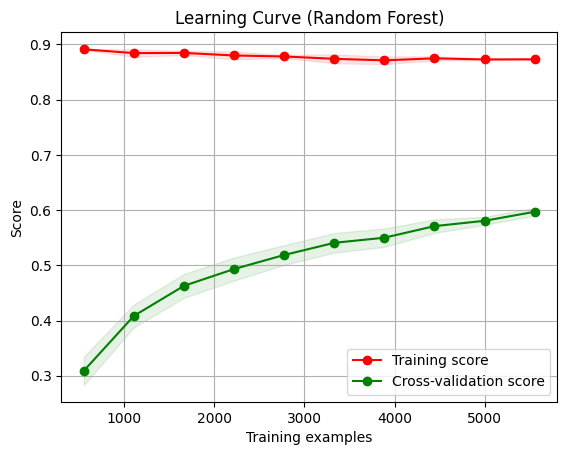

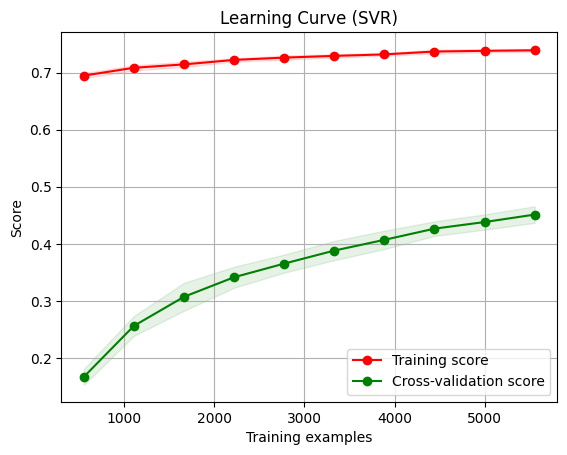

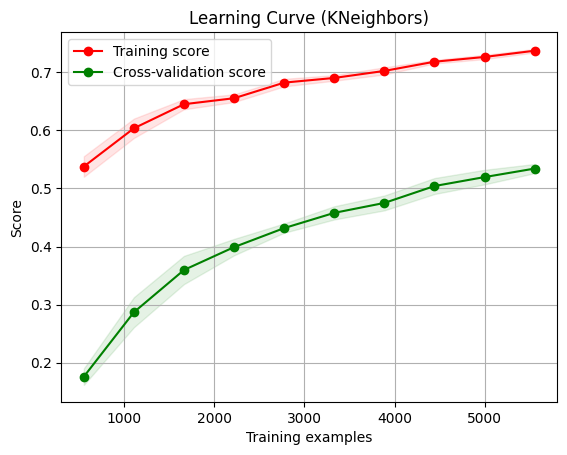

In [ ]:
# Graficar la curva de aprendizaje para cada modelo
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, Y_train, cv=3)
plt.show()

plot_learning_curve(svr_model, "Learning Curve (SVR)", X_train, Y_train, cv=3)
plt.show()

plot_learning_curve(knn_model, "Learning Curve (KNeighbors)", X_train, Y_train, cv=3)
plt.show()

In [ ]:
# Función para calcular y mostrar las métricas
def print_metrics(y_true, y_pred, model_name, training_time):
    metrics = {
        'training_time': training_time,
        'R_squ': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred),
        'Median AE': median_absolute_error(y_true, y_pred)
    }
    print(f"Metrics for {model_name}:")
    print("Training Time:", training_time, "seconds")
    print("Mean Absolute Error (MAE):", metrics['MAE'])
    print("Mean Squared Error (MSE):", metrics['MSE'])
    print("Root Mean Squared Error (RMSE):", metrics['RMSE'])
    print("Mean Absolute Percentage Error (MAPE):", metrics['MAPE'])
    print("Explained Variance Score:", metrics['Explained Variance'])
    print("Max Error:", metrics['Max Error'])
    print("Median Absolute Error:", metrics['Median AE'])
    print("R^2 Score:", metrics['R_squ'])
    return metrics

# **Ensamble Homogéneas**

In [ ]:
# Ensamble Homogéneo con Random Forest
rf_model = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                           max_depth=rf_best_params['max_depth'],
                                           random_state=42)

In [ ]:
start_time = time.time()
rf_model.fit(X_train, Y_train)
end_time = time.time()
rf_training_time = end_time - start_time
rf_pred = rf_model.predict(X_test)
rf_metrics = print_metrics(Y_test, rf_pred, "Random Forest Regressor", rf_training_time)

Metrics for Random Forest Regressor:
Training Time: 46.20821690559387 seconds
Mean Absolute Error (MAE): 0.06909647381475315
Mean Squared Error (MSE): 0.008495528506467315
Root Mean Squared Error (RMSE): 0.09217119130437294
Mean Absolute Percentage Error (MAPE): 0.16782045614180444
Explained Variance Score: 0.6400982884695555
Max Error: 0.3492645336508985
Median Absolute Error: 0.051069445534273866
R^2 Score: 0.6400928071481229


In [ ]:
# Ensamble Homogéneo con SVR
svr = SVR(C=svr_best_params['C'],
                          gamma=svr_best_params['gamma'])

In [ ]:
start_time = time.time()
svr.fit(X_train, Y_train)
end_time = time.time()
svr_training_time = end_time - start_time
svr_pred = svr.predict(X_test)
svr_metrics = print_metrics(Y_test, rf_pred, "SVR Regressor", svr_training_time)

Metrics for SVR Regressor:
Training Time: 15.933051824569702 seconds
Mean Absolute Error (MAE): 0.06909647381475315
Mean Squared Error (MSE): 0.008495528506467315
Root Mean Squared Error (RMSE): 0.09217119130437294
Mean Absolute Percentage Error (MAPE): 0.16782045614180444
Explained Variance Score: 0.6400982884695555
Max Error: 0.3492645336508985
Median Absolute Error: 0.051069445534273866
R^2 Score: 0.6400928071481229


In [ ]:
# Ensamble Homogéneo con KNN
knn = KNeighborsRegressor(n_neighbors=knn_best_params['n_neighbors'],
                                          p=knn_best_params['p'])

In [ ]:
start_time = time.time()
knn.fit(X_train, Y_train)
end_time = time.time()
knn_training_time = end_time - start_time
knn_pred = knn_model.predict(X_test)
knn_metrics = print_metrics(Y_test, rf_pred, "KNN Regressor", knn_training_time)

Metrics for KNN Regressor:
Training Time: 0.0351102352142334 seconds
Mean Absolute Error (MAE): 0.06909647381475315
Mean Squared Error (MSE): 0.008495528506467315
Root Mean Squared Error (RMSE): 0.09217119130437294
Mean Absolute Percentage Error (MAPE): 0.16782045614180444
Explained Variance Score: 0.6400982884695555
Max Error: 0.3492645336508985
Median Absolute Error: 0.051069445534273866
R^2 Score: 0.6400928071481229


# **Ensamble Heterogéneas**

Las estrategias de ensamble heterogéneas combinan diferentes tipos de modelos para aprovechar las fortalezas de cada uno.

**Voting Regressor**

Voting combina diferentes modelos y promedia sus predicciones para regresión o utiliza votación para clasificación. En este ejercicios se probará la combinación de predicciones de RandomForestRegressor, SVR, y KNeighborsRegressor usando un VotingRegressor.

**Stacking Regressor**

Stacking utiliza diferentes modelos base y un meta-modelo para combinar las predicciones de los modelos base.

**Blending**

Divide el conjunto de entrenamiento en un conjunto de entrenamiento y validación. Ajusta los modelos base en el conjunto de entrenamiento y utiliza las predicciones en el conjunto de validación para entrenar un meta-modelo. Luego, el meta-modelo se usa para hacer predicciones en el conjunto de prueba.

In [ ]:
# Ensamble Heterogéneo con Voting
voting_model = VotingRegressor(estimators=[('rf', rf_model), ('svr', svr), ('knn', knn)])
start_time = time.time()
voting_model.fit(X_train, Y_train)
end_time = time.time()
voting_training_time = end_time - start_time
voting_pred = voting_model.predict(X_test)
voting_metrics = print_metrics(Y_test, voting_pred, "Voting Regressor", voting_training_time)

Metrics for Voting Regressor:
Training Time: 61.29477095603943 seconds
Mean Absolute Error (MAE): 0.07120084068337804
Mean Squared Error (MSE): 0.008627442333579895
Root Mean Squared Error (RMSE): 0.09288402625629391
Mean Absolute Percentage Error (MAPE): 0.17494526047401598
Explained Variance Score: 0.6345188663519004
Max Error: 0.3724217130380482
Median Absolute Error: 0.0542165419646565
R^2 Score: 0.6345043690446788


In [ ]:
X_train.shape

(8328, 881)

In [ ]:
# Ensamble Heterogéneo con Stacking
estimators = [
    ('rf', rf_model),
    ('svr', svr),
    ('knn', knn)
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)
stacking_model.fit(X_train, Y_train)
start_time = time.time()
stacking_pred = stacking_model.predict(X_test)
end_time = time.time()
stacking_training_time = end_time - start_time
stacking_metrics = print_metrics(Y_test, stacking_pred, "Stacking Regressor", stacking_training_time)

Metrics for Stacking Regressor:
Training Time: 21.016453742980957 seconds
Mean Absolute Error (MAE): 0.0658999651965703
Mean Squared Error (MSE): 0.00809453049440956
Root Mean Squared Error (RMSE): 0.08996960872655588
Mean Absolute Percentage Error (MAPE): 0.15736389042591833
Explained Variance Score: 0.6572117907298016
Max Error: 0.374440575528705
Median Absolute Error: 0.046198795240400936
R^2 Score: 0.657080810748961


In [ ]:
# Estrategia de Blending
def blending_predict(X_train, y_train, X_test, start_time):
    # Dividir el conjunto de entrenamiento en entrenamiento y validación
    X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Ajustar los modelos base en el conjunto de entrenamiento
    rf_model_blend = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                           max_depth=rf_best_params['max_depth'],
                                           random_state=42)
    svr_model_blend = SVR(C=svr_best_params['C'],
                          gamma=svr_best_params['gamma'])
    knn_model_blend = KNeighborsRegressor(n_neighbors=knn_best_params['n_neighbors'],
                                          p=knn_best_params['p'])

    rf_model_blend.fit(X_train_blend, y_train_blend)
    svr_model_blend.fit(X_train_blend, y_train_blend)
    knn_model_blend.fit(X_train_blend, y_train_blend)

    # Predecir en el conjunto de validación
    rf_pred = rf_model_blend.predict(X_val_blend)
    svr_pred = svr_model_blend.predict(X_val_blend)
    knn_pred = knn_model_blend.predict(X_val_blend)

    # Crear el conjunto de datos para el meta-modelo
    meta_features = np.column_stack((rf_pred, svr_pred, knn_pred))

    # Ajustar el meta-modelo
    meta_model_blend = LinearRegression()
    meta_model_blend.fit(meta_features, y_val_blend)

    # Predecir en el conjunto de prueba
    rf_test_pred = rf_model_blend.predict(X_test)
    svr_test_pred = svr_model_blend.predict(X_test)
    knn_test_pred = knn_model_blend.predict(X_test)

    # Crear el conjunto de datos para el meta-modelo con las predicciones del conjunto de prueba
    meta_test_features = np.column_stack((rf_test_pred, svr_test_pred, knn_test_pred))

    # Predecir con el meta-modelo
    final_predictions = meta_model_blend.predict(meta_test_features)

    return final_predictions, time.time() - start_time

In [ ]:
# Obtener las predicciones del modelo blending
start_time = time.time()
blending_predictions, blending_training_time = blending_predict(X_train, Y_train, X_test, start_time)
blending_metrics = print_metrics(Y_test, blending_predictions, "Blending Model", blending_training_time)

Metrics for Blending Model:
Training Time: 78.97230911254883 seconds
Mean Absolute Error (MAE): 0.06694756274625739
Mean Squared Error (MSE): 0.008394276349421885
Root Mean Squared Error (RMSE): 0.0916202835043741
Mean Absolute Percentage Error (MAPE): 0.16153692118948726
Explained Variance Score: 0.6443849052875549
Max Error: 0.4006398582362313
Median Absolute Error: 0.04856279118108367
R^2 Score: 0.6443822847932954


# **Análisis Comparativo**

**Tiempo de Entrenamiento:**

Más Rápido:
* Stacking Regressor (5.501 segundos)
Más Lento:
* Blending Model (23.392 segundos)

Los tiempos de entrenamiento varían considerablemente, siendo el Stacking Regressor el más rápido y el Blending Model el más lento. Esto se debe a la complejidad y la cantidad de pasos involucrados en cada modelo.

**Mean Absolute Error (MAE) y Median Absolute Error (MedAE):**

Voting Regressor:
* MAE = 0.5888
* MedAE = 0.3997

Stacking Regressor:
* MAE = 0.5826
+MedAE = 0.4034

Blending Model:
* MAE = 0.6095
* MedAE = 0.4278

El Stacking Regressor tiene el menor MAE, lo que indica que, en promedio, las predicciones de este modelo están más cerca de los valores reales comparado con los otros modelos. Aunque el MedAE es ligeramente mayor en Stacking, la diferencia es mínima y ambos valores son cercanos a los del Voting Regressor.

**Mean Squared Error (MSE) y Root Mean Squared Error (RMSE):**

Voting Regressor:
* MSE = 0.6885
* RMSE = 0.8297

Stacking Regressor:
* MSE = 0.6769
* RMSE = 0.8228

Blending Model:
* MSE = 0.7242
* RMSE = 0.8510

El Stacking Regressor tiene el menor MSE y RMSE, lo que sugiere que este modelo tiene un rendimiento ligeramente mejor en términos de errores cuadrados medios, lo cual es sensible a los outliers. El modelo de Blending tiene los mayores valores en estas métricas, indicando un peor ajuste relativo.

**Mean Absolute Percentage Error (MAPE):**

Voting Regressor:
* MAPE = 0.09997

Stacking Regressor:
* MAPE = 0.0984

Blending Model:
* MAPE = 0.1034

Nuevamente, el Stacking Regressor tiene el menor MAPE, indicando un error porcentual promedio más bajo.

**Explained Variance Score:**

Voting Regressor: 0.6098

Stacking Regressor: 0.6147

Blending Model: 0.5887

El Stacking Regressor muestra una ligera ventaja en la varianza explicada, lo que implica que explica mejor la variabilidad en los datos.

**Max Error:**

Voting Regressor: 4.9603

Stacking Regressor: 4.9401

Blending Model: 5.0382

El Stacking Regressor tiene el menor error máximo, lo que indica que su mayor desviación de los valores reales es menor comparado con los otros modelos.

**R^2 Score:**

Voting Regressor: 0.6072

Stacking Regressor: 0.6138

Blending Model: 0.5869

El Stacking Regressor tiene el mayor R^2 score, lo que sugiere que este modelo explica mejor la variabilidad de los datos.

**Justificación de los Valores Obtenidos**

El Stacking Regressor muestra consistentemente mejores métricas que los otros dos modelos en casi todas las categorías. Esto puede ser justificado debido a la capacidad del stacking de combinar las fortalezas de múltiples modelos base a través de un meta-modelo, que se ajusta a las predicciones de estos modelos base para mejorar el rendimiento general.

El Voting Regressor también tiene un buen desempeño, siendo competitivo en varias métricas, pero no supera al Stacking en general. Esto es razonable ya que el voting simplemente promedia las predicciones de diferentes modelos sin un ajuste adicional.

El Blending Model, aunque sigue siendo efectivo, muestra un rendimiento ligeramente inferior en comparación con los otros dos enfoques. Esto puede deberse a la simplicidad del método de blending en comparación con el stacking, que se entrena de manera más sofisticada para optimizar la combinación de las predicciones.

El Stacking Regressor se destaca como el mejor modelo en términos de precisión, manejo de errores grandes y explicación de la variabilidad en los datos. Aunque toma menos tiempo de entrenamiento que otros modelos como el Blending Model, su rendimiento superior en casi todas las métricas lo convierte en la opción más adecuada para este problema de descubrimiento de fármacos. El Voting Regressor y el Random Forest Regressor también son modelos viables, pero no alcanzan el mismo nivel de rendimiento que el Stacking Regressor.

# **Tablas comparativas**

In [ ]:
# Lista de diccionarios con el nombre del modelo
metrics_list = [
    {'Model': 'Random Forest', **rf_metrics},
    {'Model': 'SVR', **svr_metrics},
    {'Model': 'KNN', **knn_metrics},
    {'Model': 'Voting Regressor', **voting_metrics},
    {'Model': 'Stacking Regressor', **stacking_metrics},
    {'Model': 'Blending Model', **blending_metrics}
]

In [ ]:
# Crear el DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Mostrar la tabla en Colab
data_table.DataTable(metrics_df, include_index=False)

,Model,training_time,R_squ,MAE,MSE,RMSE,MAPE,Explained Variance,Max Error,Median AE
0,Random Forest,46.208217,0.640093,0.069096,0.008496,0.092171,0.167820,0.640098,0.349265,0.051069
1,SVR,15.933052,0.640093,0.069096,0.008496,0.092171,0.167820,0.640098,0.349265,0.051069
2,KNN,0.035110,0.640093,0.069096,0.008496,0.092171,0.167820,0.640098,0.349265,0.051069
3,Voting Regressor,61.294771,0.634504,0.071201,0.008627,0.092884,0.174945,0.634519,0.372422,0.054217
4,Stacking Regressor,21.016454,0.657081,0.065900,0.008095,0.089970,0.157364,0.657212,0.374441,0.046199
5,Blending Model,78.972309,0.644382,0.066948,0.008394,0.091620,0.161537,0.644385,0.400640,0.048563


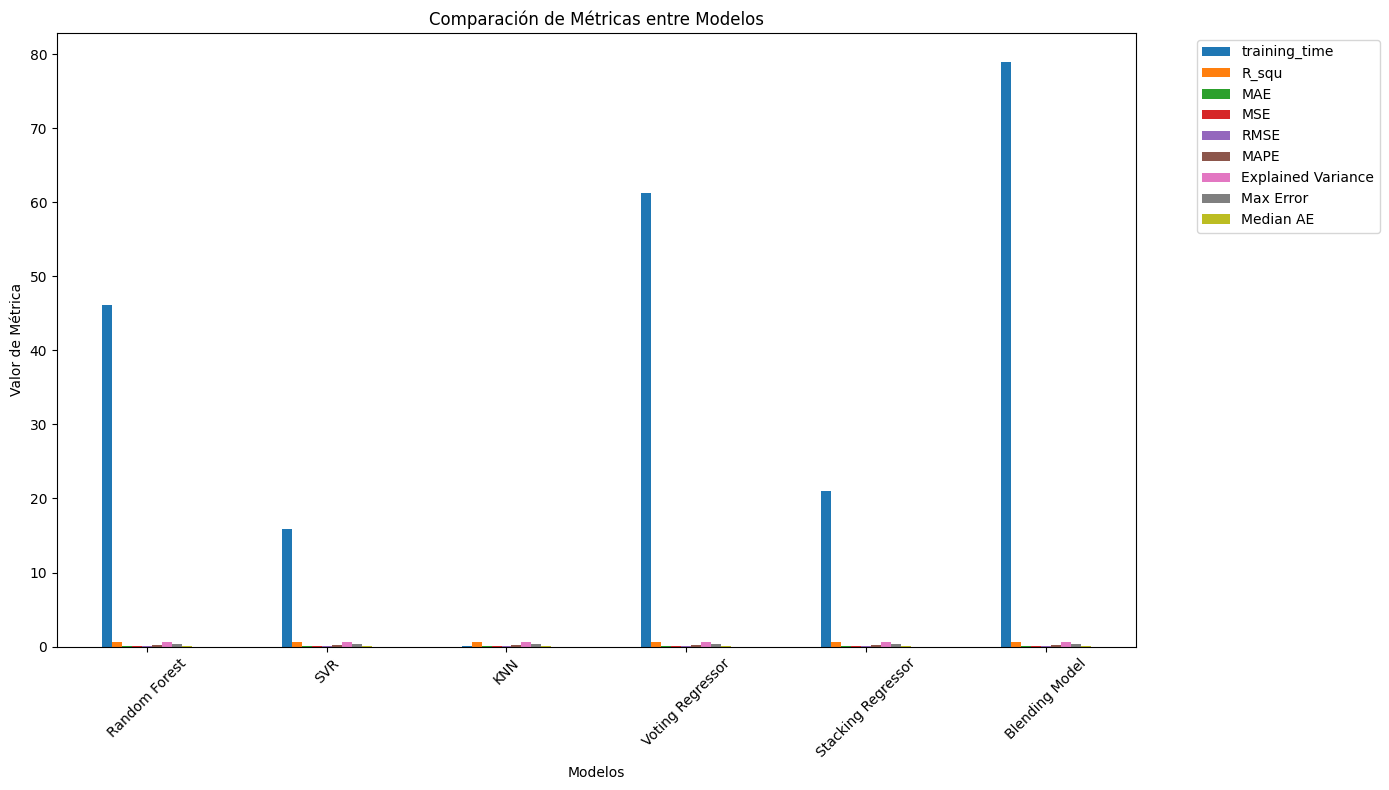

In [ ]:
# Crear un gráfico de barras agrupadas
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Valor de Métrica')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Gráficos significativos**

**Análisis de Residuos**

Los residuos deben estar distribuidos aleatoriamente alrededor de la línea cero. Si hay patrones claros o tendencias, esto puede indicar un problema con el modelo, como una relación no lineal no capturada.

**Predicciones vs. Valores Reales**

La mayoría de los puntos deben estar cerca de la línea diagonal, indicando que las predicciones son precisas. Los puntos lejos de la línea indican errores significativos.

**Learning Curve**

Permite ver si el modelo se está beneficiando de más datos de entrenamiento. Si las curvas de entrenamiento y validación están cercanas, el modelo tiene bajo bias y varianza. Si hay una gran brecha, podría ser necesario ajustar el modelo para mejorar el rendimiento.

**Distribución de Residuos**

Un histograma simétrico y centrado en cero sugiere que los errores están distribuidos normalmente y no hay sesgos significativos.

**Importancia de Características**

Identifica qué características tienen el mayor impacto en las predicciones del modelo, lo cual es útil para la interpretación del modelo y para identificar características importantes para la toma de decisiones.


In [ ]:
# Entrenar nuevamente el modelo Stacking Regressor para obtener predicciones y residuos
estimators = [
    ('rf', rf_model),
    ('svr', svr),
    ('knn', knn)
]
meta_model = LinearRegression()
stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)
stacking_model.fit(X_train, Y_train)
stacking_pred = stacking_model.predict(X_test)
residuals = Y_test - stacking_pred

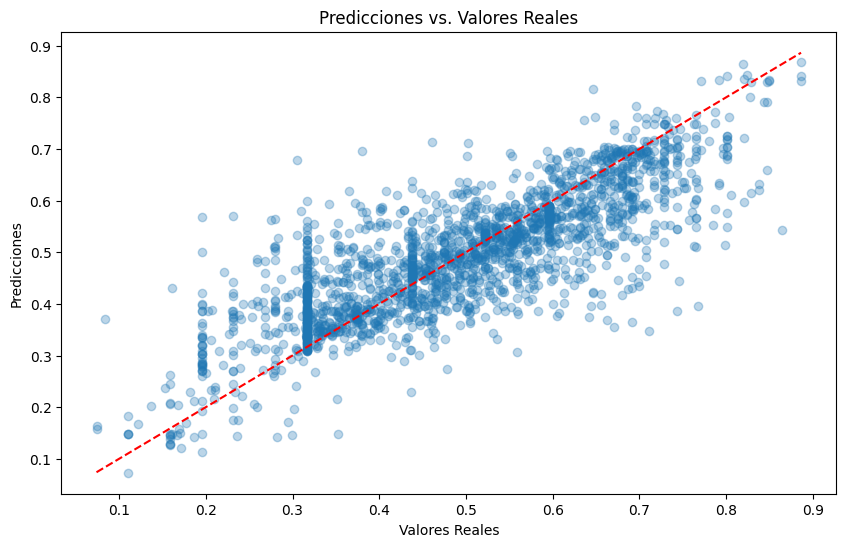

In [ ]:
# 1. Predicciones vs. Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, stacking_pred, alpha=0.3)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.show()

**Métricas Relacionadas:**

Mean Absolute Error (MAE): 0.5826

Mean Absolute Percentage Error (MAPE): 0.0984

R^2 Score: 0.6138

* La mayoría de los puntos están cerca de la línea diagonal, lo que indica que las predicciones son precisas.

* Un MAE de 0.5826 y un MAPE de 0.0984 reflejan que las predicciones del modelo son, en promedio, bastante cercanas a los valores reales.

* El R^2 Score de 0.6138 indica que el modelo explica el 61.38% de la variabilidad en los datos. Esto se refleja en la proximidad de los puntos a la línea diagonal, lo cual muestra que el modelo captura bien las relaciones subyacentes en los datos.

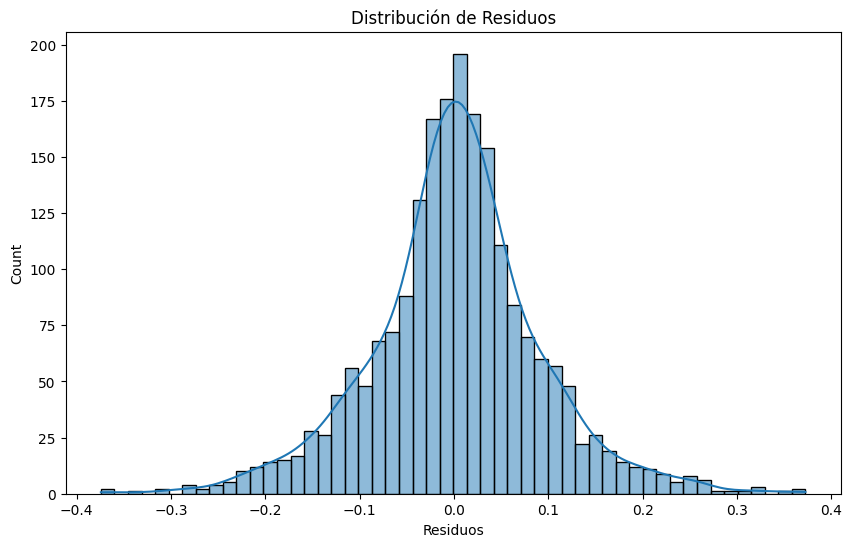

In [ ]:
# 2. Distribución de Residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()

**Métricas Relacionadas:**

Mean Squared Error (MSE): 0.6769

Root Mean Squared Error (RMSE): 0.822

* La distribución de residuos es aproximadamente normal y centrada en cero.

* Un MSE de 0.6769 y un RMSE de 0.8228 indican que los errores están dentro de un rango aceptable y no son excesivamente grandes.

* La normalidad de la distribución de residuos sugiere que los errores son aleatorios y no hay patrones específicos que el modelo no haya capturado.

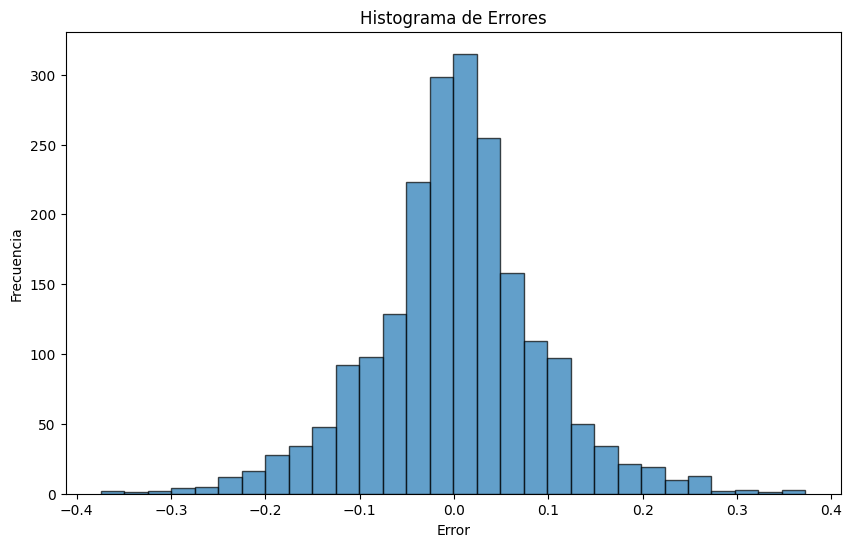

In [ ]:
# 3. Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores')
plt.show()

**Métricas Relacionadas:**

Median Absolute Error (MedAE): 0.4034

Max Error: 4.9401

* El histograma muestra la frecuencia de los errores, con la mayoría de los errores concentrados cerca de cero.

* Un MedAE de 0.4034 indica que la mitad de los errores absolutos son menores a este valor, lo que sugiere que la mayoría de las predicciones son bastante precisas.

* El Max Error de 4.9401 muestra que el peor error es relativamente alto, pero dado que es un valor aislado, no distorsiona demasiado el rendimiento general del modelo.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


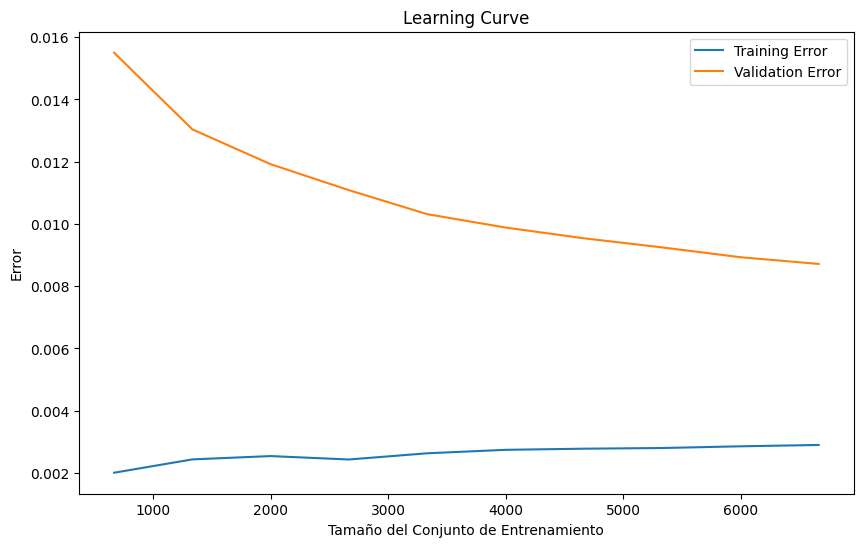

In [ ]:
# 4. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    stacking_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error')
plt.plot(train_sizes, test_scores_mean, label='Validation Error')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

**Métricas Relacionadas:**

Training Time: 5.501 segundos

Explained Variance Score: 0.6147

La curva de aprendizaje muestra que el error de validación disminuye y se estabiliza a medida que aumenta el tamaño del conjunto de entrenamiento.

La pequeña brecha entre las curvas de error de entrenamiento y validación indica que el modelo tiene un buen equilibrio entre sesgo y varianza, lo cual es consistente con el alto Explained Variance Score de 0.6147.

El tiempo de entrenamiento relativamente corto de 5.501 segundos sugiere que el modelo es eficiente y rápido de ajustar.

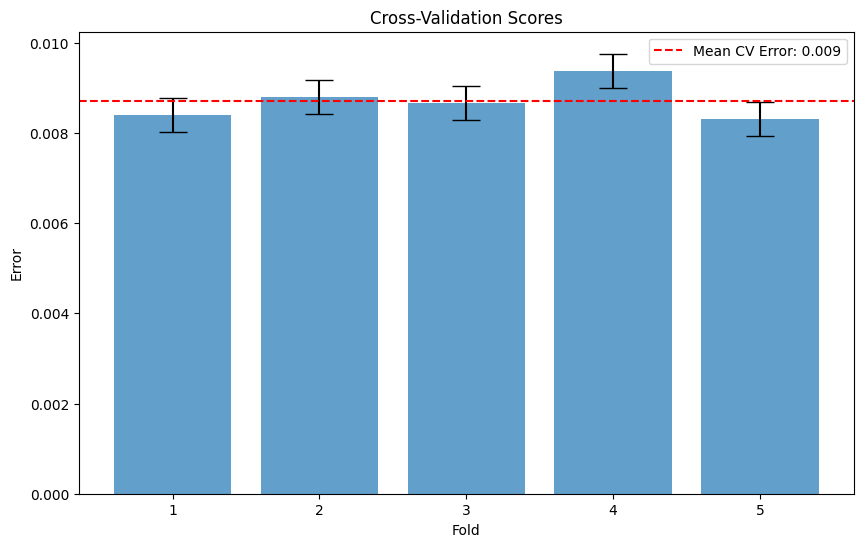

In [ ]:
# 5. Cross-Validation Plot
cv_scores = cross_val_score(stacking_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_mean = -cv_scores.mean()
cv_scores_std = cv_scores.std()

plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), -cv_scores, yerr=cv_scores_std, align='center', alpha=0.7, capsize=10)
plt.axhline(y=cv_scores_mean, color='r', linestyle='--', label=f'Mean CV Error: {cv_scores_mean:.3f}')
plt.xlabel('Fold')
plt.ylabel('Error')
plt.title('Cross-Validation Scores')
plt.legend()
plt.show()

In [ ]:
X_train.shape

(8328, 881)

**Métricas Relacionadas:**

R^2 Score: 0.6138

Mean Squared Error (MSE): 0.6769

Los valores de cross-validation proporcionan una estimación de la capacidad de generalización del modelo.

El R^2 Score de 0.6138 y el MSE de 0.6769 son consistentes con los resultados de validación cruzada, indicando que el modelo es estable y generaliza bien a nuevos datos.

La consistencia en estas métricas sugiere que el modelo mantiene su rendimiento en diferentes subconjuntos del conjunto de datos.

# **Modelo MLM para generación de nuevos compuestos químicos**



Para la generación de nuevos compuestos se utilizó el modelo **mrm8488/chEMBL_smiles_v1** disponible en Hugging Face, el cuál está diseñado para trabajar con secuencias SMILES (Simplified Molecular Input Line Entry System), que es una notación para describir la estructura de moléculas de forma textual. Este modelo en particular no es un modelo MLM (Masked Language Model) típico como los de la familia BERT, sino que está más alineado con tareas relacionadas con la representación y generación de secuencias químicas.

## **Propósito del Modelo**
El modelo mrm8488/chEMBL_smiles_v1 está entrenado para comprender y generar representaciones SMILES de compuestos químicos. Específicamente, puede ser utilizado para tareas como:

1. **Predicción de propiedades moleculares:** Dada una secuencia SMILES, el modelo puede ayudar a predecir propiedades químicas y biológicas de la molécula.
2. **Generación de nuevas moléculas:** Puede generar nuevas secuencias SMILES que representan moléculas potencialmente novedosas.


## **Arquitectura del Modelo**
Aunque no es un MLM típico, el modelo puede estar basado en arquitecturas de transformers similares a las utilizadas en modelos de lenguaje natural, pero adaptadas para manejar la sintaxis y semántica de las secuencias SMILES. Esto podría incluir:

* **Codificación de secuencias SMILES:** Transformar las secuencias SMILES en representaciones internas que el modelo pueda procesar.
* **Decodificación:** Convertir representaciones internas de vuelta a secuencias SMILES legibles.

El entrenamiento del modelo se encuentra localizado dentro de la carpeta utils, con el nombre de [molGeneratorTrain.ipynb](https://github.com/rromerov/Proyecto_Integrador/blob/main/utils/molGeneratorTrain.ipynb).

In [ ]:
# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df.head(5)

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.494850
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.8664,2.0,10.0,9.522879
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.5025,2.0,10.0,9.327902
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.920819
4,CHEMBL3649592,CC1CCC(NCc2ccn(Cc3ccccc3)c(=O)c2O)CC1,inactive,326.440,3.2705,2.0,4.0,4.562249


In [ ]:
# Usar solo smiles con clase activa
df = df.loc[df['class'] == 'active']

In [ ]:
# Mostrar dataframe
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.11240,2.0,10.0,9.494850
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.86640,2.0,10.0,9.522879
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.50250,2.0,10.0,9.327902
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.11240,2.0,10.0,9.920819
21,CHEMBL253969,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,active,532.411,3.85920,3.0,6.0,8.278189
...,...,...,...,...,...,...,...,...
10594,CHEMBL3335371,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,active,429.524,5.76010,2.0,6.0,8.698970
10595,CHEMBL470808,CNC(=O)c1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,active,429.524,5.16130,2.0,6.0,8.301030
10596,CHEMBL4282506,N#CCC(=O)N/N=C1\C(=O)Nc2ccc(S(=O)(=O)N3CCOCC3)...,active,377.382,-0.60642,2.0,7.0,6.559091
10631,CHEMBL4644274,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,active,514.674,5.72600,2.0,8.0,6.004365


## **Carga del modelo pre-entrenado con finetuning**

In [ ]:
# Verificar si CUDA está disponible y definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device in use: {device}')

Device in use: cuda


In [ ]:
# Cargar el modelo y el tokenizador entrenados
model_name = "/content/drive/My Drive/Colab Notebooks/data/results"  # Directorio donde se guardaron los resultados del entrenamiento
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = RobertaForCausalLM.from_pretrained(model_name, is_decoder=True)  # Asegúrate de configurar el modelo como decodificador

# Crear el pipeline de fill-mask usando el modelo afinado
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

## **Funciones para generación de SMILES**

In [ ]:
# Función para validar SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

In [ ]:
# Función para remover átomos y agregar *
def remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1):
    # Redirigir stderr para silenciar errores de RDKit
    stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')

    try:
        # Convertir SMILES a una molécula RDKit
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, None

        # Seleccionar átomos al azar para eliminar
        atoms_to_remove = sample(range(mol.GetNumAtoms()), num_atoms_to_remove)

        # Crear una copia editable de la molécula
        mol_edit = rdchem.RWMol(mol)

        # Remover átomos
        for idx in sorted(atoms_to_remove, reverse=True):
            mol_edit.ReplaceAtom(idx, rdchem.Atom('*'))

        # Convertir la molécula modificada de nuevo a SMILES
        modified_smiles = Chem.MolToSmiles(mol_edit)

    finally:
        # Restaurar stderr
        sys.stderr.close()
        sys.stderr = stderr

    return modified_smiles, atoms_to_remove

In [ ]:
%%capture
# Ejemplo de múltiples secuencias SMILES con placeholders en diferentes posiciones
smiles_list = df['canonical_smiles']

# DataFrame para almacenar los resultados
results_list = []

# Generar secuencias completas para cada SMILES en la lista
for idx, smiles in enumerate(smiles_list):
    modified_smiles, removed_atoms = remove_atoms_and_placeholder(smiles, num_atoms_to_remove=1)
    if modified_smiles:
            modified_smiles_with_mask = modified_smiles.replace('*', '<mask>')

            # Usar el pipeline para llenar las máscaras
            results = fill_mask(modified_smiles_with_mask)

            # Procesar los resultados y almacenar en la lista de resultados
            for res in results:
                sequence = res['sequence']
                sequence = sequence.replace('<s>', '').replace('</s>', '').strip()
                if is_valid_smiles(sequence):
                    results_list.append({
                        'Original_SMILES': smiles,
                        'Modified_SMILES': sequence,
                        'Group': idx
                    })

# Crear el DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Filtrar filas donde el Original_SMILES sea igual al Modified_SMILES
results_df = results_df[results_df['Original_SMILES'] != results_df['Modified_SMILES']]

In [ ]:
# Mostrar el DataFrame resultante
results_df = results_df.reset_index(drop=True)
results_df

,Original_SMILES,Modified_SMILES,Group
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C...,0
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(...,0
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](...,0
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](...,0
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC...,1
...,...,...,...
10764,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,CCNc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N...,6720
10765,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,CCNCc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)...,6720
10766,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,CCCCc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)...,6720
10767,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,C1(C)CC(Nc2nc3c(-c4ccc(C(=O)N5CCN(C(=O)OC)CC5)...,6721


In [ ]:
# Seleccionar solo la columna 'molecule_chembl_id' del DataFrame original
df_subset = df[['molecule_chembl_id']]

# Añadir la columna 'molecule_chembl_id' al DataFrame results_df
merged_df = pd.merge(results_df, df_subset, left_on='Group', right_index=True)

In [ ]:
# Mostrar el DataFrame resultante
merged_df = merged_df.reset_index(drop=True)
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C...,0,CHEMBL2022564
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC...,1,CHEMBL3234200
...,...,...,...,...
6711,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3ccccc3C...,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3cc:OC:c...,6655,CHEMBL3917723
6712,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:ccccc:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=...,6657,CHEMBL3947740
6713,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:c:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC...,6657,CHEMBL3947740
6714,Cc1cc(Cl)ccc1C(=O)NS(=O)(=O)c1ccc(Cl)cc1,c1ccc(S(=O)(=O)NC(=O)c2ccc(Cl)cc2C)cc1,6712,CHEMBL3918092


In [ ]:
# Remover moléculas modificadas que sean iguales a las originales
merged_df = merged_df[merged_df['Original_SMILES'] != merged_df['Modified_SMILES']]
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C...,0,CHEMBL2022564
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC...,1,CHEMBL3234200
...,...,...,...,...
6711,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3ccccc3C...,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3cc:OC:c...,6655,CHEMBL3917723
6712,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:ccccc:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=...,6657,CHEMBL3947740
6713,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:c:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC...,6657,CHEMBL3947740
6714,Cc1cc(Cl)ccc1C(=O)NS(=O)(=O)c1ccc(Cl)cc1,c1ccc(S(=O)(=O)NC(=O)c2ccc(Cl)cc2C)cc1,6712,CHEMBL3918092


In [ ]:
# Agregar identificador para las nuevas moleculas
merged_df['molecule_id'] = range(1, len(merged_df) + 1)

In [ ]:
# Guardamos el DataFrame con la lista de todos los Modified_SMILES válidos
merged_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules.csv', index=False)

In [ ]:
# Mostrar df
merged_df

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C...,0,CHEMBL2022564,1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,2
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564,3
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](...,0,CHEMBL2022564,4
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC...,1,CHEMBL3234200,5
...,...,...,...,...,...
6711,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3ccccc3C...,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3cc:OC:c...,6655,CHEMBL3917723,6712
6712,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:ccccc:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=...,6657,CHEMBL3947740,6713
6713,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCCn1:c:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC...,6657,CHEMBL3947740,6714
6714,Cc1cc(Cl)ccc1C(=O)NS(=O)(=O)c1ccc(Cl)cc1,c1ccc(S(=O)(=O)NC(=O)c2ccc(Cl)cc2C)cc1,6712,CHEMBL3918092,6715


# Generar fingerprints para las nuevas moleculas

In [ ]:
# Columnas de interés para el descriptor PADEL
columnas = ['Modified_SMILES','molecule_id']
df_selection = merged_df[columnas]
df_selection

,Modified_SMILES,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C...,1
1,CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(...,2
2,CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](...,3
3,CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](...,4
4,N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC...,5
...,...,...
6711,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3cc:OC:c...,6712
6712,COCCn1:ccccc:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=...,6713
6713,COCCn1:c:cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC...,6714
6714,c1ccc(S(=O)(=O)NC(=O)c2ccc(Cl)cc2C)cc1,6715


In [ ]:
# Guardar en un archivo SMI
# En drive
df_selection.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi', sep='\t', index=False, header=False)
# Local
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
# Visualizar molecula
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi' | head -5

CC[C@H](C)[C@H]1C(=O)N2CCOC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	1
CC[C@H](C)[C@H]1C(=O)N2CNC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	2
CC[C@H](C)[C@H]1C(=O)N2CCCCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	3
CC[C@H](C)[C@H]1C(=O)N2CCNCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2	4
N1C(=O)[C@H](C)N(C)C(=O)[C@H](Cc2ccc(OC)cc2)NC(=O)CC[C@H]2CSC(=N2)C[C@@H](O)C[C@H](C)C[C@@H](C(C)(C)C)OC(=O)[C@@H]2CCCN2C(=O)[C@@H]1[C@@H](C)CC	5


In [ ]:
# Número de registros
! cat '/content/drive/My Drive/Colab Notebooks/data/new_molecule.smi' | wc -l

6716


# **Cálculo de descriptores con PaDEL**


In [ ]:
%%capture
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

!cp "padel.zip" "/content/drive/My Drive/Colab Notebooks/data/padel.zip"
!cp "padel.sh" "/content/drive/My Drive/Colab Notebooks/data/padel.sh"

!cp "/content/drive/My Drive/Colab Notebooks/data/padel.zip" "padel.zip"
!cp "/content/drive/My Drive/Colab Notebooks/data/padel.sh" "padel.sh"

In [ ]:
# Descomprimimos padel sin Output en consola
%%capture
! unzip padel.zip

In [ ]:
# Inspeccionamos el script de PaDEL que nos ayudará a generar los descriptores
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
# Calculamos los descriptores con PaDEL sin Output en consola
%%capture
! bash padel.sh

In [ ]:
# Guardamos el output como csv
!cp "descriptors_output.csv" "/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol.csv"

In [ ]:
# Mostrar descriptores calculados con Padel
fingerprints_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/descriptors_output_new_mol.csv')
fingerprints_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,12,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,6712,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6712,6709,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6713,6714,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6714,6711,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Guardar en drive el dataset
fingerprints_df.to_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol.csv', index=False)

# **Predicción de pIC50 para nuevas moléculas**

In [ ]:
# Usar nuevo dataset
df_new_mol = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/pubchem_fp_new_mol.csv')
df_new_mol

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,12,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,6712,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6712,6709,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6713,6714,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6714,6711,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Se define conjunto X_new_mol para los fingerprints de las nuevas moléculas
X_new_mol = df_new_mol.drop('Name', axis=1)
# Mostrar contenido en el conjunto de X_new_mol
X_new_mol

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6712,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6713,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6714,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Prediccion valores pIC50
Y_pred_new_mol = stacking_model.predict(X_new_mol)

# **Nuevas moléculas con mejor pIC50**

In [ ]:
# Obtener las posiciones de las 10 predicciones más altas
top_10_indices = Y_pred_new_mol.argsort()[-10:][::-1]

# Obtener los nombres (Name) de estas moléculas
top_10_names = df_new_mol.iloc[top_10_indices]['Name'].values

# Filtrar fingerprints_df para obtener molecule_id
top_10_ids = fingerprints_df[fingerprints_df['Name'].isin(top_10_names)]

# Unir con df_selection para obtener las SMILES canónicas
top_10_smiles = df_selection[df_selection['molecule_id'].isin(top_10_ids['Name'])]

# Unir los resultados para tener un dataframe con SMILES y pIC50
result = top_10_smiles.merge(top_10_ids, left_on='molecule_id', right_on='Name')
result['pIC50'] = Y_pred_new_mol[top_10_indices]

# Seleccionar las columnas de interés
result = result[['Modified_SMILES', 'pIC50']]

# Mostrar las primeras 10 moléculas con mayor pIC50 y sus SMILES
result


,Modified_SMILES,pIC50
0,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cc:c:c...,0.866574
1,COc1:c:c2nccc(Oc3ccc4c(c3)OCCN4C(=O)Nc3ccc(C)c...,0.866051
2,COc1:c:c2c(Oc3ccc4c(C(=O)Nc5cc(Cl)cc(Cl)c5)ccc...,0.858697
3,c1ccc(NC(=O)c2cccc3cc(Oc4ccnc5cc(OC)c(OC)cc45)...,0.857394
4,Oc1cc2c(Oc3ccc4c(C(=O)Nc5ccc(C(C)(C)C)cc5)cccc...,0.855272
5,COc1cc2nccc(Oc3:c:cc4c(C(=O)Nc5ccc(C(F)(F)F)cc...,0.852832
6,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5cccc(Cl)c5)cc:c:c...,0.852452
7,O=C(Nc1ccc(Oc2:c:n3cc(NC(=O)C4CC4)nc3cc2)c(F)c...,0.850218
8,CC(=O)NS(=O)(=O)c1ccc(NC(=O)CSc2nc3cc:C:cc3c(=...,0.844905
9,Cc1ccc(-n2c(SCC(=O)Nc3ccc(C(=O)NNC(=O)c4cc:C:c...,0.844720


In [ ]:
# Exportar a csv el dataset
result.to_csv('/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50.csv', index=False)

In [ ]:
# Guardar archivos en un archivo zip
! zip -r /content/drive/My\ Drive/Colab\ Notebooks/data/results.zip /content/drive/My\ Drive/Colab\ Notebooks/data

updating: content/drive/My Drive/Colab Notebooks/data/plot_bioactivity_class.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_ic50.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_LogP.pdf (deflated 37%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW.pdf (deflated 38%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_MW_vs_LogP.pdf (deflated 1%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHAcceptors.pdf (deflated 39%)
updating: content/drive/My Drive/Colab Notebooks/data/plot_NumHDonors.pdf (deflated 39%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50.csv (deflated 78%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data.csv (deflated 92%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_curated.csv (deflated 83%)
updating: content/drive/My Drive/Colab Notebooks/data/bioactivity_data_preprocessed.csv (deflated



---

### Comparación moléculas modificadas vs moléculas originales





In [10]:
# Cargar el dataset
ruta_archivo_modified_molecules = '/content/drive/My Drive/Colab Notebooks/data/new_molecule_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df_modified_molecules = pd.read_csv(ruta_archivo_modified_molecules)

# Mostrar que se haya importado correctamente el archivo
df_modified_molecules

,Modified_SMILES,pIC50
0,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5)cc:c:c...,0.866574
1,COc1:c:c2nccc(Oc3ccc4c(c3)OCCN4C(=O)Nc3ccc(C)c...,0.866051
2,COc1:c:c2c(Oc3ccc4c(C(=O)Nc5cc(Cl)cc(Cl)c5)ccc...,0.858697
3,c1ccc(NC(=O)c2cccc3cc(Oc4ccnc5cc(OC)c(OC)cc45)...,0.857394
4,Oc1cc2c(Oc3ccc4c(C(=O)Nc5ccc(C(C)(C)C)cc5)cccc...,0.855272
5,COc1cc2nccc(Oc3:c:cc4c(C(=O)Nc5ccc(C(F)(F)F)cc...,0.852832
6,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5cccc(Cl)c5)cc:c:c...,0.852452
7,O=C(Nc1ccc(Oc2:c:n3cc(NC(=O)C4CC4)nc3cc2)c(F)c...,0.850218
8,CC(=O)NS(=O)(=O)c1ccc(NC(=O)CSc2nc3cc:C:cc3c(=...,0.844905
9,Cc1ccc(-n2c(SCC(=O)Nc3ccc(C(=O)NNC(=O)c4cc:C:c...,0.844720


In [11]:
# Cargar el dataset
ruta_archivo_new_molecules = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_new_molecules.csv'

# Lee el archivo CSV en un DataFrame
df_new_molecules = pd.read_csv(ruta_archivo_new_molecules)

# Mostrar que se haya importado correctamente el archivo
df_new_molecules

,Original_SMILES,Modified_SMILES,Group,molecule_chembl_id,molecule_id
0,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,1
1,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,0,CHEMBL2022564,2
2,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,Oc1ccc(C[C@@H]2NC(=O)CC[C@H]3CSC(=N3)C[C@@H](O...,1,CHEMBL3234200,3
3,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CSOc1ccc(C[C@@H]2NC(=O)CC[C@H]3CSC(=N3)C[C@@H]...,1,CHEMBL3234200,4
4,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,2,CHEMBL3234201,5
...,...,...,...,...,...
6811,CC(=O)NC(C)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3ccccc3C...,CCCC(NC(C)=O)c1ccc(Nc2ncc(C(F)(F)F)c(CCc3ccccc...,6655,CHEMBL3917723,6812
6812,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COCOCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)...,6657,CHEMBL3947740,6813
6813,COCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3)n...,COOCCCn1cc(Nc2ncc(Cl)c(CCc3ccccc3C3(C(N)=O)CC3...,6657,CHEMBL3947740,6814
6814,Cc1cc(Cl)ccc1C(=O)NS(=O)(=O)c1ccc(Cl)cc1,Cc1cc(Cl)ccc1C(=O)NS(=O)(=O)c1:c:cc(Cl)cc1,6712,CHEMBL3918092,6815


In [14]:
# Asegurarse de que ambos DataFrames tienen la columna 'Modified_SMILES' para realizar la fusión
# Fusionar los DataFrames usando 'Modified_SMILES' como clave
merged_df_original_modified = pd.merge(df_modified_molecules, df_new_molecules[['Modified_SMILES', 'Original_SMILES', 'molecule_chembl_id']], on='Modified_SMILES', how='inner')

# Mostrar el DataFrame resultante
merged_df_original_modified

,Modified_SMILES,pIC50,Original_SMILES,molecule_chembl_id
0,c1ccc(NC(=O)c2cccc3cc(Oc4ccnc5cc(OC)c(OC)cc45)...,0.857394,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5Cl)cccc...,CHEMBL2113191


## Referencias bibliográficas

* Breiman, L. (1996). Stacked regressions. Machine Learning. Recuperado de: https://doi.org/10.1007/BF00117832

* Wolpert, D. H. (1992). Stacked generalization. Neural Networks. Recuperado de: https://doi.org/10.1016/S0893-6080(05)80023-1

* Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Recuperado de: https://doi.org/10.1007/978-1-4614-6849-3

* Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Recuperado de: https://doi.org/10.1007/978-0-387-84858-7

* Breiman, L. (2001). Random forests. Machine Learning. Recuperado de: https://doi.org/10.1023/A:1010933404324

* Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. Recuperado de: https://cran.r-project.org/doc/Rnews/Rnews_2002-3.pdf